# 画像をresnetに入れて特徴量を計算して，その特徴量をUMAPを使って２次元に落としてプロットした
# 特徴量は，ある程度時代ごとに分かれていそう

In [2]:
import numpy as np
import pandas as pd

from torch import nn
import torch

from torchvision.models import resnet18, alexnet, vgg16
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
import os

import umap
from IPython.display import clear_output

In [3]:
class FeatureExtractorRes(nn.Module):
    def __init__(self):
        super().__init__()
        original_model = resnet18(pretrained=True)
        self.head = nn.Sequential(*[
            original_model.conv1,
            original_model.bn1,
            original_model.relu,
            original_model.maxpool])
        self.layer1 = original_model.layer1
        self.layer2 = original_model.layer2
        self.layer3 = original_model.layer3
        self.layer4 = original_model.layer4
        
        self.module_list = nn.ModuleList([self.head, self.layer1, self.layer2, self.layer3, self.layer4])
        print(self.module_list)
        
    def extract_minibatch(self, x, target_layer):
        batch_inds = np.append(np.arange(0, len(x), 32), len(x))
        x_fea_rec = []
        for k in tqdm_notebook(range(len(batch_inds) - 1)):
            x_batch = x[batch_inds[k] : batch_inds[k+1]]
            x_fea = self.extract(x_batch, target_layer)
            x_fea_rec.append(x_fea)
        
        x_fea_concat = np.concatenate(x_fea_rec)
        return x_fea_concat
                
        
    def extract(self, x, target_layer):
        for k, m in enumerate(self.module_list):
            x = m(x)
            if k == target_layer:
                break
        return x.detach().numpy()

class FeatureExtractorAlex(nn.Module):
    def __init__(self):
        super().__init__()
        original_model = alexnet(pretrained=True).features
        self.layer1 = original_model[0]
        self.layer2 = original_model[1:4]
        self.layer3 = original_model[4:7]
        self.layer4 = original_model[7:9]
        self.layer5 = original_model[9:11]
        
        self.module_list = nn.ModuleList([self.layer1, self.layer2, self.layer3, self.layer4, self.layer5])
        print(self.module_list)
        
    def extract_minibatch(self, x, target_layer):
        batch_inds = np.append(np.arange(0, len(x), 32), len(x))
        x_fea_rec = []
        for k in tqdm_notebook(range(len(batch_inds) - 1)):
            x_batch = x[batch_inds[k] : batch_inds[k+1]]
            x_fea = self.extract(x_batch, target_layer)
            x_fea_rec.append(x_fea)
        
        x_fea_concat = np.concatenate(x_fea_rec)
        return x_fea_concat
                
        
    def extract(self, x, target_layer):
        for k, m in enumerate(self.module_list):
            x = m(x)
            if k == target_layer:
                break
        return x.detach().numpy()



class FeatureExtractorVGG(nn.Module):
    def __init__(self):
        super().__init__()
        original_model = vgg16(pretrained=True).features
        self.layer1 = original_model[0:5]
        self.layer2 = original_model[5:10]
        self.layer3 = original_model[10:17]
        self.layer4 = original_model[17:24]
        self.layer5 = original_model[24:31]

        self.module_list = nn.ModuleList([self.layer1, self.layer2, self.layer3, self.layer4, self.layer5])
        print(self.module_list)
        
    def extract_minibatch(self, x, target_layer):
        batch_inds = np.append(np.arange(0, len(x), 32), len(x))
        x_fea_rec = []
        for k in tqdm_notebook(range(len(batch_inds) - 1)):
            x_batch = x[batch_inds[k] : batch_inds[k+1]]
            x_fea = self.extract(x_batch, target_layer)
            x_fea_rec.append(x_fea)
        
        x_fea_concat = np.concatenate(x_fea_rec)
        return x_fea_concat
                
        
    def extract(self, x, target_layer):
        for k, m in enumerate(self.module_list):
            x = m(x)
            if k == target_layer:
                break
        return x.detach().numpy()


In [6]:
data = pd.read_pickle("./resized_data_128.pkl")
x, y = data["x"], data["y"]
x.shape, y.shape

((8151, 3, 128, 128), (8151,))

In [7]:
data_dir = "res18/"
# data_dir = "alex/"
# data_dir = "vgg16/"
os.makedirs(data_dir, exist_ok=True)
if "res18" in data_dir:
    model = FeatureExtractorRes()
if "alex" in data_dir:
    model = FeatureExtractorAlex()
if "vgg16" in data_dir:
    model = FeatureExtractorVGG()
    
np.random.seed(42)

ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
  

## extract feature from image by pretrained CNN

In [ ]:
for target_layer in range(5):
    print(target_layer)
    out_fn = data_dir + "x_features_{}.pkl".format(target_layer)

    if os.path.exists(out_fn) is False:
        x_features = model.extract_minibatch(torch.Tensor(x), target_layer)
        print("dim : ",  x_features.shape)
        pd.to_pickle(x_features, out_fn)

## compress features to 2d

In [5]:
print("---- start compress ----")
for target_layer in range(5):
    print(target_layer)
    inp_fn = data_dir + "x_features_{}.pkl".format(target_layer)
    out_fn = inp_fn.replace(".", "_2d.")
    if os.path.exists(out_fn) is False:
        x_features = pd.read_pickle(inp_fn)
        x_features_flatten = x_features.reshape(len(x_features), -1)
        x2d = umap.UMAP().fit_transform(x_features_flatten)
        pd.to_pickle({"x2d" : x2d, "y" : y}, out_fn)

0
1
2
3
4
---- start compress ----
0
1
2
3
4


## plot

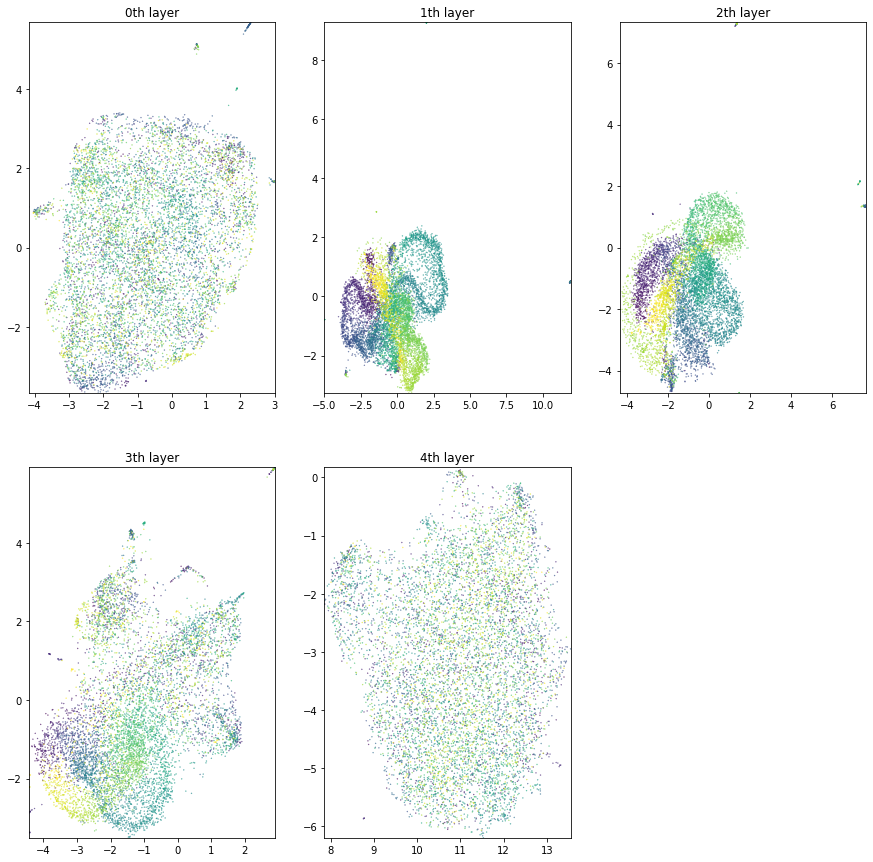

In [22]:
plt.figure(figsize=(15,15))
for target_layer in range(5):
    inp_fn = data_dir + "x_features_{}_2d.pkl".format(target_layer)
    data = pd.read_pickle(inp_fn)
    x2d, y = data["x2d"], data["y"]
    plt.subplot(2,3,target_layer+1)
    plt.scatter(x2d[:,0], x2d[:,1], c=y/40, s = 0.1)
    plt.title("{}th layer".format(target_layer))
    plt.xlim([np.min(x2d[:,0]), np.max(x2d[:,0])])
    plt.ylim([np.min(x2d[:,1]), np.max(x2d[:,1])])
plt.savefig(data_dir + "/2d.jpg")
plt.show()